In [1]:
from main import *

/home/junyeobe/.local/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.13) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [2]:
# toy example

train_sub = [1,2,3]
train_x0, train_y0 = make_train_dataset(train_sub, 0)
# score_model0 = train_scorenet(train_x0, train_y0)

train length :  432


In [6]:
batch_size = 1
samples0 = sampling(score_model0, sample_batch_size=batch_size)

# generated_signal0 = return_to_signal(samples0)

NameError: name 'score_model0' is not defined

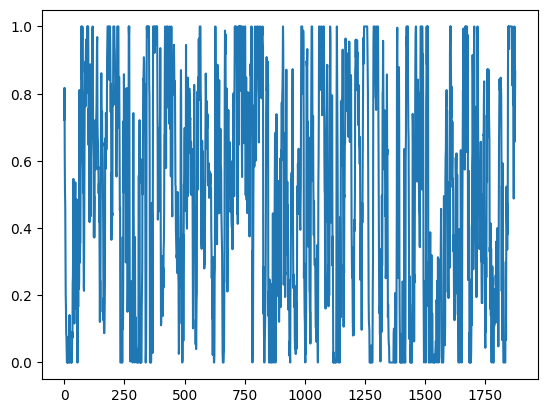

In [7]:
import matplotlib.pyplot as plt

'''
for sample in samples0:
    plt.plot(sample[0][0].cpu())
    plt.show()
    break

for signal in generated_signal0[0]:
    plt.plot(signal)
    plt.show()
    break
'''

for x in train_x0:
    plt.plot(x[0])
    plt.show()
    break

In [ ]:
generated_signal0